## Preparations



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product               # Cartesian product for iterators

Make sure you put all of the given python files in the same directories before running this cell!


In [ ]:
import sys, os

import gridworld as W                       # basic grid-world MDPs
import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P                            # helper-functions for plotting

In [ ]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.7 MB/s eta 0:00:00


In [ ]:
%matplotlib widget
plt.rcParams['figure.figsize'] = [9, 5]     # set default figure size
style = {                                   # global style for plots
    'border': {'color': 'red', 'linewidth': 0.5},
}

In [ ]:
def to_one_hot_array(input_array):

  num_unique_values = 4
  one_hot_array = np.zeros((len(input_array), num_unique_values), dtype=int)

  for i, val in enumerate(input_array):
    one_hot_array[i, val] = 1

  return one_hot_array




# Setting up the MDP

In [ ]:
def setup_mdp(size, p_slip):
    # create our world
    world = W.IcyGridWorld(size= size, p_slip= p_slip)

    # set up the reward function
    reward = np.zeros(world.n_states) - 0.25
    reward[-1] = 1.0
    reward[8] = .6
    reward[9] = -0.6

    reward[5:8] = -0.6
    reward[16:20] = -0.6

    # set up terminal states
    terminal = [24]

    return world, reward, terminal




# Comment out the appropriate line of code

### Deterministic Environment (Problem 1 & 3) ###
world, reward, terminal = setup_mdp(size = 5, p_slip = 0)

# ### Stochastic Environment (Problem 2 & 4) ###
# world, reward, terminal = setup_mdp(size = 5, p_slip = 0.3)

# Generate Expert Trajectories

In [ ]:
def generate_expert_trajectories_optimal(world, reward, terminal, num_trajectories = 200):
    n_trajectories = num_trajectories         # the number of "expert" trajectories
    discount = 0.9              # discount for constructing an "expert" policy
    weighting = lambda x: x**1  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value, Q = S.value_iteration(world.p_transition, reward, discount)


    # create our deterministic policy using the value function
    policy = S.optimal_policy_from_value(world, value)
    print('Expert policy:\n', policy)


    # a function that executes our deterministic policy by choosing actions according to it
    policy_exec = T.policy_adapter(policy)


    # generate trajectories
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exec, start, terminal))

    return tjs, policy, Q, True




In [ ]:
# adjust suboptimality
def stochastic_policy_from_value_adjusted(world, value, suboptimal_factor):
    """
    Compute a stochastic policy from the given value function.

    Args:
        world: The `GridWorld` instance for which the the policy should be
            computed.
        value: The value-function dictating the policy as table
            `[state: Integer] -> value: Float`
        w: A weighting function `(value: Float) -> value: Float` applied to
            all state-action values before normalizing the results, which
            are then used as probabilities. I.e. choosing `x -> x**2` here
            will cause the preference of suboptimal actions to decrease
            quadratically compared to the preference of the optimal action.

    Returns:
        The stochastic policy given the provided arguments as table
        `[state: Integer, action: Integer] -> probability: Float`
        describing a probability distribution p(action | state) of selecting
        an action given a state.
    """
    value = np.exp(value)       # for softmax
    def create_suboptimal(x):
      return np.power(x, suboptimal_factor)

    q = np.array([
        np.array([create_suboptimal(value[world.state_index_transition(s, a)]) for a in range(world.n_actions)])
        for s in range(world.n_states)
    ])

    return q / np.sum(q, axis=1)[:, None]

## generate trajectories
def generate_expert_trajectories_suboptimal(world, reward, terminal, sub_factor, num_trajectories = 200):
    n_trajectories = num_trajectories         # the number of "expert" trajectories
    discount = 0.9              # discount for constructing an "expert" policy
    weighting = lambda x: x**1  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value, Q = S.value_iteration(world.p_transition, reward, discount)

    # call the adjusted suboptimal policy function
    policy = stochastic_policy_from_value_adjusted(world, value, sub_factor)
    print('suboptimal expert policy:\n', np.round(policy, 3))

    # # a function that executes our stochastic policy by choosing actions according to it
    policy_exec = T.stochastic_policy_adapter(policy)

    # generate trajectories
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exec, start, terminal))

    return tjs, policy, Q, False




In [ ]:
#Comment out the appropriate Line of Code


# Fully Optimal Expert (Problem 1)
# trajectories, expert_policy, Q, optimal = generate_expert_trajectories_optimal(world, reward, terminal, num_trajectories = 20)

# Fully Optimal Expert (Problem 2)
# trajectories, expert_policy, Q, optimal = generate_expert_trajectories_optimal(world, reward, terminal, num_trajectories = 40)


# Suboptimal Expert (Problem 3)
trajectories, expert_policy, Q, optimal = generate_expert_trajectories_suboptimal(world, reward, terminal, 1.9, num_trajectories = 40)


# Suboptimal Expert (Problem 4)
# trajectories, expert_policy, Q, optimal = generate_expert_trajectories_suboptimal(world, reward, terminal, num_trajectories = 40)



suboptimal expert policy:
 [[0.55  0.163 0.124 0.163]
 [0.618 0.047 0.175 0.16 ]
 [0.557 0.032 0.287 0.124]
 [0.082 0.031 0.747 0.14 ]
 [0.115 0.197 0.574 0.115]
 [0.346 0.071 0.49  0.093]
 [0.628 0.016 0.286 0.07 ]
 [0.798 0.009 0.159 0.033]
 [0.289 0.051 0.561 0.099]
 [0.064 0.117 0.806 0.013]
 [0.335 0.128 0.519 0.019]
 [0.505 0.043 0.422 0.03 ]
 [0.497 0.021 0.438 0.045]
 [0.474 0.014 0.443 0.069]
 [0.109 0.017 0.865 0.009]
 [0.289 0.118 0.563 0.029]
 [0.326 0.024 0.635 0.015]
 [0.333 0.009 0.648 0.01 ]
 [0.335 0.006 0.652 0.007]
 [0.045 0.005 0.944 0.006]
 [0.719 0.127 0.127 0.027]
 [0.844 0.022 0.123 0.011]
 [0.874 0.015 0.103 0.008]
 [0.901 0.01  0.084 0.005]
 [0.467 0.043 0.467 0.022]]


# Training a Behavioral Cloning Model on the trajectories of the expert

In [ ]:
states = []
actions = []


In [ ]:
for traject in trajectories:
  for t in traject._t:
    states.append(t[0])
    actions.append(t[1])


# USE your favorite Supervised Learning Algorithm to train a model on the states and actions dataset where the states list is the input data and the actions list is the output. Once you trained your model extract a policy from it for each of the 25 states.

# Make sure you use 1-hot encoding for the states and actions spaces!

In [ ]:
expert_policy

array([[0.55034218, 0.16274628, 0.12416527, 0.16274628],
       [0.61830753, 0.04722476, 0.17477264, 0.15969507],
       [0.55745237, 0.03199323, 0.286683  , 0.1238714 ],
       [0.08163463, 0.03119823, 0.74676726, 0.14039987],
       [0.11457742, 0.19705674, 0.57378842, 0.11457742],
       [0.34570656, 0.07126774, 0.48961343, 0.09341227],
       [0.62841618, 0.01582234, 0.28563154, 0.07012994],
       [0.7984176 , 0.00942852, 0.15879781, 0.03335607],
       [0.28863869, 0.05097864, 0.56125519, 0.09912748],
       [0.06424236, 0.11734906, 0.80558029, 0.01282829],
       [0.33523988, 0.12757942, 0.51861035, 0.01857036],
       [0.50541932, 0.04250077, 0.42207094, 0.03000897],
       [0.49666724, 0.02050464, 0.43771598, 0.04511213],
       [0.47386502, 0.01372903, 0.44337793, 0.06902802],
       [0.10908022, 0.01691471, 0.86530629, 0.00869879],
       [0.28947626, 0.11849086, 0.56288384, 0.02914904],
       [0.32639174, 0.0236529 , 0.63466565, 0.0152897 ],
       [0.33318746, 0.00861565,

# Plot of the MDP (with corresponding reward and expert behavior)





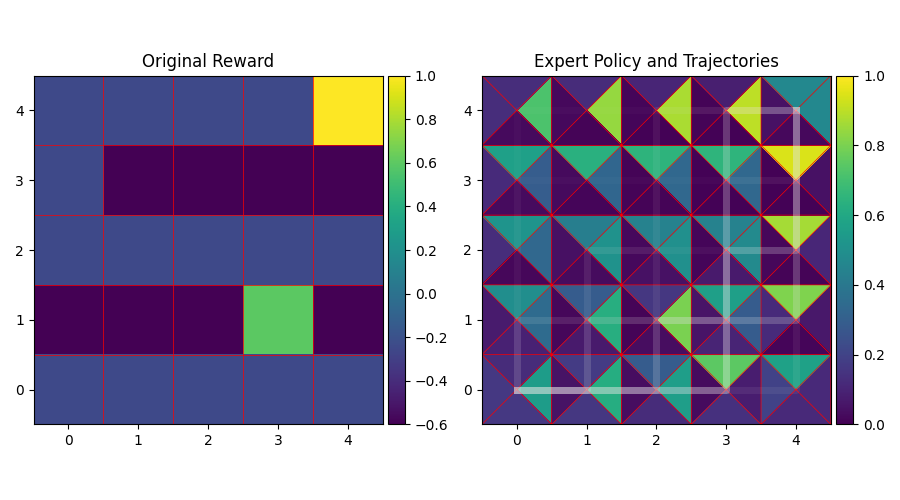

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Expert Policy and Trajectories')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)



if optimal:
  p = P.plot_stochastic_policy(ax, world, to_one_hot_array(expert_policy), **style)
else:
  p = P.plot_stochastic_policy(ax, world, expert_policy, **style)







for t in trajectories:
    P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)


fig.colorbar(p, cax=cax)


fig.tight_layout()
plt.show()

## With that done, we have all the prequisites we need to run the MaxEnt IRL algorithm. We need to define some helper functions first

In [ ]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:                  # for each trajectory
        for s in t.states():                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

In [ ]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:                  # for each trajectory
        p[t.transitions()[0][0]] += 1.0     # increment starting state

    return p / len(trajectories)            # normalize

In [ ]:
def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states

    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states)                             # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(2 * n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions))            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]

        # sum over all actions
        zs = za.sum(axis=1)

    # 3. compute local action probabilities
    p_action = za / zs[:, None]

    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, 2 * n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, 2 * n_states):                    # longest trajectory: n_states

        # for all states
        for s_to in range(n_states):

            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

In [ ]:
def maxent_irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute feature expectation from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)

    # compute starting-state probabilities from trajectories
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # gradient descent optimization
    omega = init(n_features)        # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check

    # collect reward data
    epochs_infos = []

    optim.reset(omega)              # re-start optimizer
    while delta > eps:              # iterate until convergence
        omega_old = omega.copy()

        # compute per-state reward from features
        reward = features.dot(omega)

        # collect reward
        epochs_infos.append(reward.tolist())

        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)

        # re-compute detla for convergence check
        delta = np.max(np.abs(omega_old - omega))

    # re-compute per-state reward and return
    final_reward =features.dot(omega)
    epochs_infos.append(final_reward.tolist())

    return epochs_infos, final_reward

# True Reward vs MaxEnt Reward

## Also plot the optimal policies derived from both reward functions as well as from BC

In [ ]:
# set up features: we use one feature vector per state
features = W.state_features(world)

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# Computing the R function through inverse reinforcement learning
epoch_rewards, reward_maxent = maxent_irl(world.p_transition, features, terminal, trajectories, optim, init)

In [ ]:
# write to file
import json

file_name = 'me_gridworld_sub_1.9_40traj.json'
print("----")
print("shape: ", np.array(epoch_rewards).shape)
print("----")
print(epoch_rewards[-1])
with open(file_name, 'w') as m:
  json.dump(epoch_rewards, m)

----
shape:  (375, 25)
----
[0.47606229106152625, 0.54378868403363, 0.604759346697494, 0.6970738269733693, 0.5125660186680495, 0.3441456545226936, 0.4418193245249913, 0.5398026231148737, 0.946623840021361, 0.5783285966923003, 0.4648868919788218, 0.48670370381876693, 0.46448691385135865, 0.6334847318845437, 0.5925997881292547, 0.5878505259868883, 0.5390957429699609, 0.5146282039278253, 0.5092250040069344, 0.6339518344858933, 0.6360630394831931, 0.5940867584393695, 0.5517774475397783, 0.6332198103683508, 1.149383383146397]


In [ ]:
print(reward)


[-0.25 -0.25 -0.25 -0.25 -0.25 -0.6  -0.6  -0.6   0.6  -0.6  -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.6  -0.6  -0.6  -0.6  -0.25 -0.25 -0.25 -0.25
  1.  ]


In [ ]:
# read in optimal policy
with open('me_gridworld.json', 'r') as file:
    data = json.load(file)
print(data[-1])

[0.21469735679068233, 0.5163729367977856, 0.6677769536693576, 0.809235968168669, 0.4370477286472355, 0.2880879830771089, 0.32477308537879357, 0.30944461791334826, 0.8565085827866274, 0.35318616208725157, 0.45513115347357874, 0.4530489500412084, 0.39785856591962465, 0.8532130905687791, 0.7034304686543957, 0.5695632209852425, 0.5499223370201347, 0.4989488544573127, 0.3416223498012167, 0.7166554314726287, 0.6324633058688518, 0.603277723709802, 0.5453426633594861, 0.4670991682151769, 1.1492937781528314]


In [ ]:
print(reward_maxent)

[1.04740154 0.79187604 0.78022032 1.06760484 0.78633818 0.56857937
 0.55929059 0.86107661 1.19991845 0.92603585 0.57493934 0.79239917
 0.92555456 0.80735329 0.94094112 1.05100567 0.93441059 0.98439023
 0.87841485 1.03812455 0.73887818 0.70949248 0.83533682 1.27805614
 1.1640808 ]


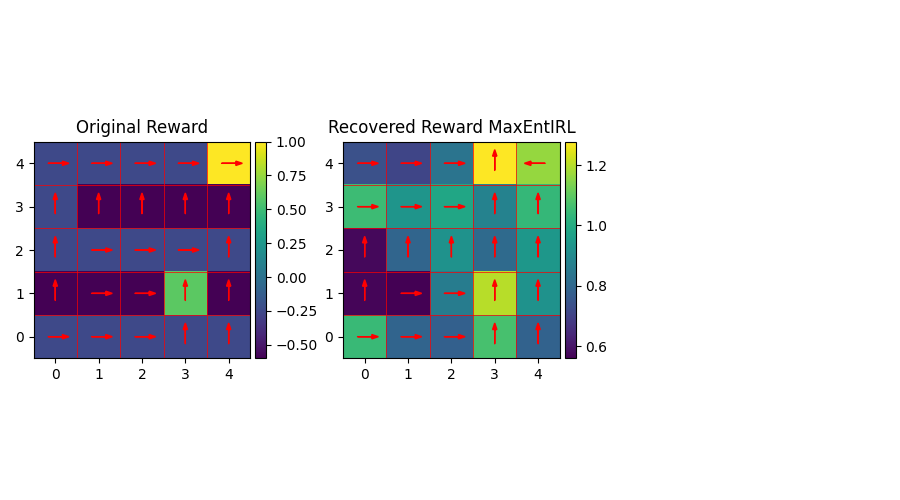

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward, 0.9), color='red')
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(132)
ax.title.set_text('Recovered Reward MaxEntIRL')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_maxent, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_maxent, 0.9), color='red')
fig.colorbar(p, cax=cax)


# ax = fig.add_subplot(133)
# ax.title.set_text('BC Policy')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# p = P.plot_stochastic_policy(ax, world, to_one_hot_array(bc_policy), **style)

fig.colorbar(p, cax=cax)


fig.tight_layout()
plt.show()

In [ ]:
print('True reward:', reward)


In [ ]:
print('Learnt MaxEnt reward:', np.round(reward_maxent,2 ))

In [ ]:
def calculate_value_function(reward, dynamics, policy, discount_factor=0.9, tol=1e-6, max_iterations=1000):
    num_states, _, num_actions = dynamics.shape
    value_function = np.zeros(num_states)


    for iteration in range(max_iterations):
        prev_value_function = np.copy(value_function)

        for state in range(num_states):
            action_probs = policy[state, :]
            action_value = 0

            for action in range(num_actions):
                next_state_values = np.sum(dynamics[state, :, action] * prev_value_function)
                action_value += action_probs[action] * (reward[state] + discount_factor * next_state_values)

            value_function[state] = action_value

        if np.max(np.abs(value_function - prev_value_function)) < tol:
            break

    return value_function

Value function using the true Reward functions

# Value function plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create sample 1D arrays of size 25
if optimal:
  values1 = calculate_value_function(reward, world.p_transition, to_one_hot_array(expert_policy))
else:
  values1 = calculate_value_function(reward, world.p_transition, expert_policy)

values2 = calculate_value_function(reward, world.p_transition,to_one_hot_array(S.optimal_policy(world, reward_maxent, 0.9)) )
values3 = calculate_value_function(reward, world.p_transition, to_one_hot_array(bc_policy))

# Create subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterate through each subplot
for ax, values in zip(axes, [values1, values2, values3]):
    # Rearrange the values to match the desired corner arrangement
    values_arranged = np.flipud(values.reshape(5, 5))

    # Use the 'viridis' colormap to map values to colors
    im = ax.imshow(values_arranged, cmap='viridis', interpolation='nearest')

    # Add text annotations for each cell
    for i in range(5):
        for j in range(5):
            ax.text(j, i, f'{values_arranged[i, j]:.2f}', ha='center', va='center', color='white')

    # Set title for each subplot
    # ax.set_title(f'Array {values[0]:.2f} - {values[-1]:.2f}')

    # Remove x and y ticks for better layout
    ax.set_xticks([])
    ax.set_yticks([])

# Add a colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of colorbar
fig.colorbar(im, cax=cax)



# Adjust layout for better spacing
# plt.tight_layout()

axes[0].set_title('Expert Policy Value Function')
axes[1].set_title('MaxEnt Policy Value Function')
axes[2].set_title('BC Policy Value Function')


plt.show()


# References

* [Abbel & Ng 2004]: https://doi.org/10.1145/1015330.1015430
* [Bishop 2006]: https://www.springer.com/us/book/9780387310732
* [Jaynes 1957]: https://doi.org/10.1103/physrev.106.620
* [Kivinen et. al. 1997]: https://doi.org/10.1006/inco.1996.2612
* [Ng et al. 99]: https://dl.acm.org/citation.cfm?id=645528.657613
* [Osa et al. 2018]: https://arxiv.org/abs/1811.06711
* [Ziebart et al. 2008]: http://www.cs.cmu.edu/~bziebart/publications/maximum-entropy-inverse-reinforcement-learning.html
* [Ziebart 2010]: https://www.cs.cmu.edu/~bziebart/publications/thesis-bziebart.pdf
* Reused code from: https://github.com/qzed/irl-maxent